[I 2025-03-21 13:20:27,983] A new study created in memory with name: no-name-7b043a97-b792-4c5b-8732-4e0456d8d7c2
C:\Users\coope\AppData\Local\Temp\ipykernel_9912\1876875389.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\coope\AppData\Local\Temp\ipykernel_9912\1876875389.py:31: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\coope\AppData\Local\Temp\ipykernel_9912\1876875389.py:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0.

Best trial:
  Value: 0.9976
  Params: 
    n_estimators: 487
    learning_rate: 0.2750817130686155
    max_depth: 4
    subsample: 0.7128437668338901
    colsample_bytree: 0.5441737932947687

Optimized XGBoost Accuracy: 0.9982139313355824
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2365
           1       1.00      1.00      1.00      2674

    accuracy                           1.00      5039
   macro avg       1.00      1.00      1.00      5039
weighted avg       1.00      1.00      1.00      5039



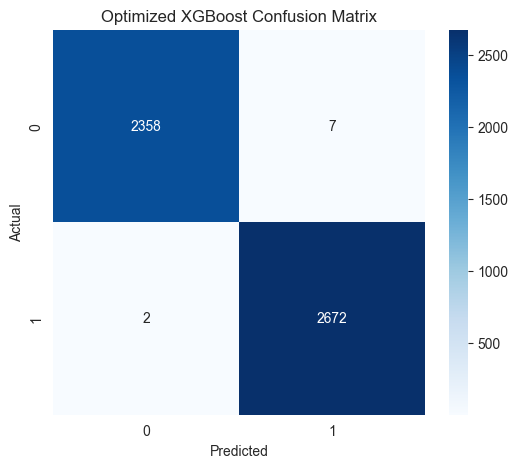

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load data
file_path = "Data/Train_data.csv"
df = pd.read_csv(file_path)

# Encode categorical features
categorical_columns = df.select_dtypes(include='object').columns
for col in categorical_columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Split data
X = df.drop(columns='class')
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define objective for Optuna
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
        "random_state": 42,
        "use_label_encoder": False,
        "eval_metric": "logloss"
    }
    
    model = XGBClassifier(**param)
    # Using cross-validation for robustness
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring="accuracy")
    return cv_scores.mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500)

print("Best trial:")
trial = study.best_trial
print("  Value: {:.4f}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Train best model
best_params = trial.params
best_params["random_state"] = 42
best_params["use_label_encoder"] = False
best_params["eval_metric"] = "logloss"

best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = best_model.predict(X_test)
print("\nOptimized XGBoost Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Optimized XGBoost Confusion Matrix")
plt.show()
